In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time
import shap


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

In [3]:
# 1layers
def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation):
    
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    model = Sequential()
    model.add(LSTM(units = nodes_per_layer, activation=activation, 
                  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(256))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.001))
    # model.save_weights(weights_file)

    return model

In [4]:
import shap
class LSTMModelWrapper:
    def __init__(self, model, input_shape):
        """
        Wrapper for LSTM models to work with SHAP.

        Parameters:
        - model: Trained LSTM model.
        - input_shape: Tuple (timesteps, features) of the original model input shape.
        """
        self.model = model
        self.timesteps, self.features = input_shape

    def predict(self, X_flat):
        """
        Predict function for SHAP that reshapes flat input back to 3D.

        Parameters:
        - X_flat: 2D numpy array [samples, timesteps * features].

        Returns:
        - Predictions from the LSTM model.
        """
        # Reshape to 3D: [samples, timesteps, features]
        X_reshaped = X_flat.reshape(-1, self.timesteps, self.features)
        return self.model.predict(X_reshaped)

def explain_lstm_model(model, X_train, X_test, timesteps, features):
    """
    Explains an LSTM model using SHAP.

    Parameters:
    - model: Trained LSTM model.
    - X_train: Training data in 3D shape [samples, timesteps, features].
    - X_test: Test data in 3D shape [samples, timesteps, features].
    - timesteps: Number of timesteps for the LSTM model input.
    - features: Number of features for the LSTM model input.

    Returns:
    - SHAP values for the test data.
    """
    # Flatten training and testing data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Wrap the LSTM model
    lstm_wrapper = LSTMModelWrapper(model, (timesteps, features))

    # Use SHAP KernelExplainer
    explainer = shap.KernelExplainer(lstm_wrapper.predict, X_train_flat[:10])  # Use a subset for background data
    shap_values = explainer.shap_values(X_test_flat)

    return shap_values, explainer

def reshape_shap_values(shap_values, original_shape):
    """
    Reshape SHAP values to match the original input shape.

    Parameters:
        shap_values (np.ndarray): SHAP values, typically a 2D array.
        original_shape (tuple): Desired shape, typically (samples, timesteps, features).

    Returns:
        np.ndarray: Reshaped SHAP values.
    """
    # Vérifiez que le produit des dimensions correspond
    if shap_values.shape[1] != np.prod(original_shape[1:]):
        raise ValueError("SHAP values cannot be reshaped to the desired shape. Check dimensions.")
    
    # Reshape des SHAP values
    reshaped_shap = shap_values.reshape(original_shape)
    return reshaped_shap

#### FD003

In [5]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD003.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR','htBleed','W31','W32']
remaining_sensors = ["Ps30", "NRc", "W31", "BPR"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 125
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(24720, 27) (16596, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,0.0,100.0,0.0,0.378788,0.341211,0.279748,0.0,...,0.238238,0.618635,0.0,0.272727,0.0,0.0,0.546584,0.469595,125,-0.0_0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.403623,0.371855,0.295333,0.0,...,0.270487,0.639660,0.0,0.320574,0.0,0.0,0.515568,0.505576,125,0.0_-0.0_100.0
2,1,3,-0.0,-0.0,100.0,0.0,0.376607,0.365007,0.349504,0.0,...,0.273559,0.596319,0.0,0.302918,0.0,0.0,0.478323,0.472777,125,-0.0_-0.0_100.0
3,1,4,-0.0,0.0,100.0,0.0,0.426586,0.372434,0.306566,0.0,...,0.265180,0.574722,0.0,0.320574,0.0,0.0,0.471081,0.455219,125,-0.0_0.0_100.0
4,1,5,0.0,0.0,100.0,0.0,0.370454,0.395376,0.307426,0.0,...,0.268241,0.570330,0.0,0.331090,0.0,0.0,0.495162,0.473204,125,0.0_0.0_100.0


In [6]:
%%time

# 	RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 43	15.404917	0.0	8.255290e+02	0.0	237.311462	0.0	0.10	[64]	0.2	tanh	32	35
results003 = pd.DataFrame()

for SEED in range(1):
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 35
    epochs = 40
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results003 = pd.concat([results003, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results003.to_csv('results/base/fd003.csv')

(21320, 35, 4) (21320, 1) (100, 35, 4)

Epoch 1/40

667/667 [==============================] - 8s 9ms/step - loss: 1966.1342 - val_loss: 1224.0942
Epoch 2/40
667/667 [==============================] - 6s 9ms/step - loss: 517.8073 - val_loss: 504.7370
Epoch 3/40
667/667 [==============================] - 6s 9ms/step - loss: 455.6265 - val_loss: 517.4324
Epoch 4/40
667/667 [==============================] - 6s 8ms/step - loss: 416.0543 - val_loss: 557.5160
Epoch 5/40
667/667 [==============================] - 6s 9ms/step - loss: 373.1064 - val_loss: 473.7141
Epoch 6/40
667/667 [==============================] - 6s 9ms/step - loss: 339.5740 - val_loss: 383.8164
Epoch 7/40
667/667 [==============================] - 6s 9ms/step - loss: 327.0514 - val_loss: 453.4135
Epoch 8/40
667/667 [==============================] - 6s 8ms/step - loss: 308.6820 - val_loss: 316.5836
Epoch 9/40
667/667 [==============================] - 6s 9ms/step - loss: 300.0205 - val_loss: 342.8273
Epoch 10/40
667/667 [

In [7]:
results003

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,15.330737,0.0,1237.835092,0.0,235.031479,0.0,[64],0.2,tanh,32,35,234.995295


### Shap explanation Generation

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

728/728 [==============================] - 3s 4ms/step


  1%|          | 1/100 [00:03<06:14,  3.78s/it]

728/728 [==============================] - 3s 3ms/step


  2%|▏         | 2/100 [00:07<05:48,  3.55s/it]

728/728 [==============================] - 2s 3ms/step


  3%|▎         | 3/100 [00:10<05:34,  3.45s/it]

728/728 [==============================] - 3s 4ms/step


  4%|▍         | 4/100 [00:14<05:42,  3.57s/it]

728/728 [==============================] - 3s 4ms/step


  5%|▌         | 5/100 [00:18<05:59,  3.78s/it]

728/728 [==============================] - 3s 4ms/step


  6%|▌         | 6/100 [00:22<05:54,  3.77s/it]

728/728 [==============================] - 3s 3ms/step


  7%|▋         | 7/100 [00:25<05:39,  3.65s/it]

728/728 [==============================] - 3s 4ms/step


  8%|▊         | 8/100 [00:29<05:29,  3.59s/it]

728/728 [==============================] - 3s 4ms/step


  9%|▉         | 9/100 [00:32<05:32,  3.66s/it]

728/728 [==============================] - 3s 5ms/step


 10%|█         | 10/100 [00:37<05:46,  3.85s/it]

728/728 [==============================] - 4s 5ms/step


 11%|█         | 11/100 [00:41<06:06,  4.12s/it]

728/728 [==============================] - 3s 4ms/step


 12%|█▏        | 12/100 [00:45<05:44,  3.92s/it]

728/728 [==============================] - 3s 4ms/step


 13%|█▎        | 13/100 [00:49<05:46,  3.99s/it]

728/728 [==============================] - 3s 4ms/step


 14%|█▍        | 14/100 [00:53<05:44,  4.00s/it]

728/728 [==============================] - 3s 4ms/step


 15%|█▌        | 15/100 [00:57<05:32,  3.91s/it]

728/728 [==============================] - 3s 4ms/step


 16%|█▌        | 16/100 [01:01<05:32,  3.96s/it]

728/728 [==============================] - 3s 5ms/step


 17%|█▋        | 17/100 [01:05<05:43,  4.14s/it]

728/728 [==============================] - 3s 4ms/step


 18%|█▊        | 18/100 [01:09<05:29,  4.02s/it]

728/728 [==============================] - 3s 4ms/step


 19%|█▉        | 19/100 [01:13<05:17,  3.92s/it]

728/728 [==============================] - 3s 4ms/step


 20%|██        | 20/100 [01:17<05:21,  4.02s/it]

728/728 [==============================] - 3s 4ms/step


 21%|██        | 21/100 [01:21<05:07,  3.90s/it]

728/728 [==============================] - 3s 5ms/step


 22%|██▏       | 22/100 [01:25<05:05,  3.92s/it]

728/728 [==============================] - 3s 4ms/step


 23%|██▎       | 23/100 [01:29<05:02,  3.93s/it]

728/728 [==============================] - 3s 4ms/step


 24%|██▍       | 24/100 [01:32<04:59,  3.94s/it]

728/728 [==============================] - 3s 5ms/step


 25%|██▌       | 25/100 [01:37<04:58,  3.98s/it]

728/728 [==============================] - 3s 4ms/step


 26%|██▌       | 26/100 [01:40<04:49,  3.92s/it]

728/728 [==============================] - 3s 4ms/step


 27%|██▋       | 27/100 [01:45<04:53,  4.03s/it]

728/728 [==============================] - 3s 5ms/step


 28%|██▊       | 28/100 [01:48<04:46,  3.98s/it]

728/728 [==============================] - 3s 4ms/step


 29%|██▉       | 29/100 [01:52<04:32,  3.83s/it]

728/728 [==============================] - 2s 3ms/step


 30%|███       | 30/100 [01:55<04:18,  3.69s/it]

728/728 [==============================] - 3s 4ms/step


 31%|███       | 31/100 [01:59<04:08,  3.60s/it]

728/728 [==============================] - 3s 4ms/step


 32%|███▏      | 32/100 [02:02<04:05,  3.61s/it]

728/728 [==============================] - 2s 3ms/step


 33%|███▎      | 33/100 [02:06<03:56,  3.53s/it]

728/728 [==============================] - 2s 3ms/step


 34%|███▍      | 34/100 [02:09<03:49,  3.48s/it]

728/728 [==============================] - 2s 3ms/step


 35%|███▌      | 35/100 [02:12<03:40,  3.39s/it]

728/728 [==============================] - 3s 4ms/step


 36%|███▌      | 36/100 [02:16<03:38,  3.42s/it]

728/728 [==============================] - 3s 4ms/step


 37%|███▋      | 37/100 [02:19<03:36,  3.44s/it]

728/728 [==============================] - 3s 4ms/step


 38%|███▊      | 38/100 [02:23<03:36,  3.50s/it]

728/728 [==============================] - 3s 4ms/step


 39%|███▉      | 39/100 [02:27<03:44,  3.68s/it]

728/728 [==============================] - 3s 5ms/step


 40%|████      | 40/100 [02:31<03:52,  3.87s/it]

728/728 [==============================] - 3s 4ms/step


 41%|████      | 41/100 [02:35<03:41,  3.75s/it]

728/728 [==============================] - 3s 4ms/step


 42%|████▏     | 42/100 [02:39<03:39,  3.78s/it]

728/728 [==============================] - 3s 3ms/step


 43%|████▎     | 43/100 [02:42<03:28,  3.65s/it]

728/728 [==============================] - 2s 3ms/step


 44%|████▍     | 44/100 [02:45<03:18,  3.55s/it]

728/728 [==============================] - 3s 4ms/step


 45%|████▌     | 45/100 [02:49<03:19,  3.63s/it]

728/728 [==============================] - 3s 3ms/step


 46%|████▌     | 46/100 [02:52<03:07,  3.47s/it]

728/728 [==============================] - 3s 4ms/step


 47%|████▋     | 47/100 [02:55<03:00,  3.41s/it]

728/728 [==============================] - 3s 3ms/step


 48%|████▊     | 48/100 [02:59<02:55,  3.38s/it]

728/728 [==============================] - 2s 3ms/step


 49%|████▉     | 49/100 [03:02<02:51,  3.36s/it]

728/728 [==============================] - 3s 4ms/step


 50%|█████     | 50/100 [03:06<02:50,  3.41s/it]

728/728 [==============================] - 3s 4ms/step


 51%|█████     | 51/100 [03:09<02:48,  3.44s/it]

728/728 [==============================] - 3s 3ms/step


 52%|█████▏    | 52/100 [03:13<02:45,  3.45s/it]

728/728 [==============================] - 3s 4ms/step


 53%|█████▎    | 53/100 [03:16<02:48,  3.59s/it]

728/728 [==============================] - 3s 4ms/step


 54%|█████▍    | 54/100 [03:20<02:44,  3.58s/it]

728/728 [==============================] - 3s 4ms/step


 55%|█████▌    | 55/100 [03:24<02:48,  3.75s/it]

728/728 [==============================] - 3s 4ms/step


 56%|█████▌    | 56/100 [03:28<02:44,  3.75s/it]

728/728 [==============================] - 3s 4ms/step


 57%|█████▋    | 57/100 [03:32<02:43,  3.81s/it]

728/728 [==============================] - 3s 4ms/step


 58%|█████▊    | 58/100 [03:35<02:37,  3.74s/it]

728/728 [==============================] - 3s 4ms/step


 59%|█████▉    | 59/100 [03:40<02:39,  3.90s/it]

728/728 [==============================] - 3s 4ms/step


 60%|██████    | 60/100 [03:44<02:37,  3.93s/it]

728/728 [==============================] - 3s 4ms/step


 61%|██████    | 61/100 [03:48<02:33,  3.93s/it]

728/728 [==============================] - 3s 4ms/step


 62%|██████▏   | 62/100 [03:51<02:27,  3.89s/it]

728/728 [==============================] - 3s 5ms/step


 63%|██████▎   | 63/100 [03:56<02:28,  4.02s/it]

728/728 [==============================] - 3s 4ms/step


 64%|██████▍   | 64/100 [04:00<02:21,  3.93s/it]

728/728 [==============================] - 3s 4ms/step


 65%|██████▌   | 65/100 [04:04<02:18,  3.95s/it]

728/728 [==============================] - 3s 4ms/step


 66%|██████▌   | 66/100 [04:08<02:16,  4.02s/it]

728/728 [==============================] - 3s 4ms/step


 67%|██████▋   | 67/100 [04:11<02:09,  3.93s/it]

728/728 [==============================] - 2s 3ms/step


 68%|██████▊   | 68/100 [04:15<01:58,  3.69s/it]

728/728 [==============================] - 3s 4ms/step


 69%|██████▉   | 69/100 [04:18<01:52,  3.63s/it]

728/728 [==============================] - 2s 3ms/step


 70%|███████   | 70/100 [04:21<01:45,  3.53s/it]

728/728 [==============================] - 2s 3ms/step


 71%|███████   | 71/100 [04:25<01:40,  3.47s/it]

728/728 [==============================] - 3s 4ms/step


 72%|███████▏  | 72/100 [04:28<01:37,  3.49s/it]

728/728 [==============================] - 3s 4ms/step


 73%|███████▎  | 73/100 [04:32<01:35,  3.52s/it]

728/728 [==============================] - 2s 3ms/step


 74%|███████▍  | 74/100 [04:35<01:29,  3.43s/it]

728/728 [==============================] - 2s 3ms/step


 75%|███████▌  | 75/100 [04:38<01:25,  3.40s/it]

728/728 [==============================] - 3s 4ms/step


 76%|███████▌  | 76/100 [04:42<01:20,  3.34s/it]

728/728 [==============================] - 2s 3ms/step


 77%|███████▋  | 77/100 [04:45<01:16,  3.32s/it]

728/728 [==============================] - 3s 3ms/step


 78%|███████▊  | 78/100 [04:48<01:13,  3.34s/it]

728/728 [==============================] - 3s 4ms/step


 79%|███████▉  | 79/100 [04:52<01:13,  3.49s/it]

728/728 [==============================] - 4s 5ms/step


 80%|████████  | 80/100 [04:57<01:16,  3.85s/it]

728/728 [==============================] - 4s 6ms/step


 81%|████████  | 81/100 [05:02<01:21,  4.29s/it]

728/728 [==============================] - 4s 5ms/step


 82%|████████▏ | 82/100 [05:07<01:19,  4.39s/it]

728/728 [==============================] - 3s 4ms/step


 83%|████████▎ | 83/100 [05:11<01:13,  4.32s/it]

728/728 [==============================] - 3s 4ms/step


 84%|████████▍ | 84/100 [05:14<01:05,  4.09s/it]

728/728 [==============================] - 3s 4ms/step


 85%|████████▌ | 85/100 [05:18<00:59,  3.98s/it]

728/728 [==============================] - 3s 5ms/step


 86%|████████▌ | 86/100 [05:22<00:56,  4.03s/it]

728/728 [==============================] - 2s 3ms/step


 87%|████████▋ | 87/100 [05:25<00:49,  3.79s/it]

728/728 [==============================] - 3s 4ms/step


 88%|████████▊ | 88/100 [05:29<00:44,  3.74s/it]

728/728 [==============================] - 3s 4ms/step


 89%|████████▉ | 89/100 [05:33<00:40,  3.69s/it]

728/728 [==============================] - 3s 4ms/step


 90%|█████████ | 90/100 [05:37<00:38,  3.84s/it]

728/728 [==============================] - 3s 4ms/step


 91%|█████████ | 91/100 [05:40<00:33,  3.73s/it]

728/728 [==============================] - 2s 3ms/step


 92%|█████████▏| 92/100 [05:44<00:28,  3.58s/it]

728/728 [==============================] - 3s 4ms/step


 93%|█████████▎| 93/100 [05:47<00:25,  3.69s/it]

728/728 [==============================] - 3s 3ms/step


 94%|█████████▍| 94/100 [05:51<00:21,  3.62s/it]

728/728 [==============================] - 3s 4ms/step


 95%|█████████▌| 95/100 [05:55<00:18,  3.61s/it]

728/728 [==============================] - 3s 4ms/step


 96%|█████████▌| 96/100 [05:58<00:14,  3.65s/it]

728/728 [==============================] - 3s 4ms/step


 97%|█████████▋| 97/100 [06:02<00:11,  3.71s/it]

728/728 [==============================] - 3s 4ms/step


 98%|█████████▊| 98/100 [06:06<00:07,  3.64s/it]

728/728 [==============================] - 3s 4ms/step


 99%|█████████▉| 99/100 [06:09<00:03,  3.63s/it]

728/728 [==============================] - 3s 4ms/step


100%|██████████| 100/100 [06:13<00:00,  3.74s/it]


<Figure size 500x200 with 0 Axes>

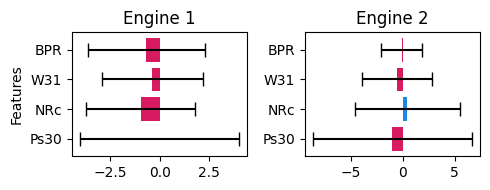

In [8]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

test_array_susbset = test_array[0:100]
test_array_susbset.shape

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:100], test_array_susbset, timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array_susbset.reshape(test_array_susbset.shape[0], -1))

# shap_values.shape
samples = shap_values.shape[0]
features = len(remaining_sensors)
list_of_shapes = [shap_values[i].reshape(-1,features) for i in range(samples)]


##explain with sign
# Calcul de la moyenne et de l'écart-type
lis_df_shap = []
plt.figure(figsize=(5, 2))
for i, shap_values_2D in enumerate(list_of_shapes[:2]):
    # plt.subplot(2,2,i+1)
    shap_values_squeeze = shap_values_2D
    mean_shap = shap_values_squeeze.mean(axis=0)
    std_shap = shap_values_squeeze.std(axis=0)

    # Création des noms de variables
    column_names = remaining_sensors

    # DataFrame
    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap,
        "SHAP Std": std_shap
    })

    # Couleurs SHAP standards
    shap_blue = '#1E88E5'
    shap_red = '#D81B60'

    # Choix de la couleur selon le signe
    shap_df["Couleur"] = shap_df["SHAP Value"].apply(lambda x: shap_blue if x >= 0 else shap_red)
    lis_df_shap.append(shap_df)

plt.figure(figsize=(5, 2))
for kk, shap_df in enumerate(lis_df_shap[:2]):
    # print(kk)
    plt.subplot(1,2, kk+1)
    # Tracé des barres une par une avec la bonne couleur
    # plt.figure(figsize=(6, len(shap_df) * 0.6))
    for i, row in shap_df.iterrows():
        plt.barh(
            y=row["Variable"],
            width=row["SHAP Value"],
            xerr=row["SHAP Std"],
            color=row["Couleur"],
            # edgecolor='black',
            capsize=5
        )
    if kk>1:
        plt.xlabel("Mean shap value")
    if (kk+1)%2!=0:
        plt.ylabel("Features")
    plt.title(f"Engine {kk+1}")
    plt.tight_layout()
plt.savefig("images/fd003_shape_std.png")
plt.show()

#explain without sign

# Dégradé bleu → rouge (faible → fort)
custom_cmap = LinearSegmentedColormap.from_list("shap_cmap", ['#1E88E5', '#D81B60'])

lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    shap_values_squeeze = shap_values_2D
    mean_shap = np.abs(shap_values_squeeze).mean(axis=0)

    column_names = remaining_sensors

    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap
    })

    # Tri décroissant
    shap_df = shap_df.sort_values("SHAP Value", ascending=False).reset_index(drop=True)

    # Normalisation des valeurs entre 0 et 1 pour le dégradé
    norm = plt.Normalize(shap_df["SHAP Value"].min(), shap_df["SHAP Value"].max())
    shap_df["Couleur"] = [custom_cmap(norm(val)) for val in shap_df["SHAP Value"]]

    lis_df_shap.append(shap_df)

# # Affichage
# plt.figure(figsize=(5, 2))
# for kk, shap_df in enumerate(lis_df_shap[:2]):
#     plt.subplot(1, 2, kk + 1)

#     for i, row in enumerate(shap_df.itertuples()):
#         plt.barh(
#             y=i,
#             width=row._2,  # SHAP Value
#             color=row.Couleur,
#             #  height=0.6,
#             # edgecolor='black'
#         )

#     # Axe Y
#     plt.yticks(ticks=range(len(shap_df)), labels=shap_df["Variable"])
#     plt.gca().invert_yaxis()

#     if kk > 1:
#         plt.xlabel("Mean |SHAP value|")
#     if (kk + 1) % 2 != 0:
#         plt.ylabel("Features")

#     plt.title(f"Engine {kk + 1}")

# plt.tight_layout()
# plt.savefig("images/fd003_shape_abs.png")
# plt.show()

Shape reshaped: (100, 35, 4)


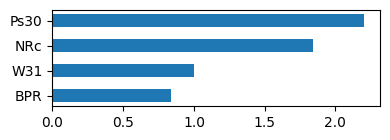

In [9]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)

list_shap_values = []
for i in range(samples):
    shap_values_2D = shap_values[i].reshape(-1,features)
    list_shap_values.append(np.abs(shap_values_2D).mean(axis=0))  # Somme sur samples et timesteps
somme_abs_par_feature002 = np.array(list_shap_values).mean(axis = 0)
# remaining_sensors001 = remaining_sensors
somme_abs_par_feature002

# Transformer en array (au cas où ce n’est pas encore fait)
values = np.array(somme_abs_par_feature002)
labels = np.array(remaining_sensors)

# Trier les valeurs et labels par ordre décroissant
indices = np.argsort(values)[::-1]
sorted_values = values[indices]
sorted_labels = labels[indices]

# Tracer le barh trié
plt.figure(figsize=(4, 1.5))
plt.barh(sorted_labels, sorted_values, height=0.5)
plt.gca().invert_yaxis()  # Affiche la plus grande valeur en haut
plt.tight_layout()
plt.savefig("images/fd003_mean_abs.png")
plt.show()
# plt.figure(figsize=(5, 1))# Set the figure size
# plt.barh(remaining_sensors, somme_abs_par_feature001, height=0.4)
# # Axe Y
# plt.yticks(ticks=range(len(remaining_sensors)), labels=remaining_sensors)
# plt.gca().invert_yaxis()

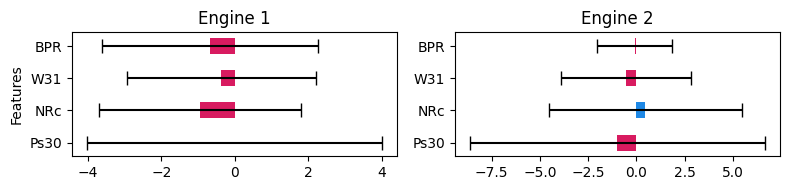

In [10]:
# Calcul de la moyenne et de l'écart-type
lis_df_shap = []
plt.figure(figsize=(8, 2))
for i, shap_values_2D in enumerate(list_of_shapes[:2]):
    # plt.subplot(2,2,i+1)
    shap_values_squeeze = shap_values_2D
    mean_shap = shap_values_squeeze.mean(axis=0)
    std_shap = shap_values_squeeze.std(axis=0)

    # Création des noms de variables
    column_names = remaining_sensors

    # DataFrame
    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap,
        "SHAP Std": std_shap
    })

    # Couleurs SHAP standards
    shap_blue = '#1E88E5'
    shap_red = '#D81B60'

    # Choix de la couleur selon le signe
    shap_df["Couleur"] = shap_df["SHAP Value"].apply(lambda x: shap_blue if x >= 0 else shap_red)
    lis_df_shap.append(shap_df)

# plt.figure(figsize=(12, 7))
for kk, shap_df in enumerate(lis_df_shap):
    # print(kk)
    plt.subplot(1,2, kk+1)
    # Tracé des barres une par une avec la bonne couleur
    # plt.figure(figsize=(6, len(shap_df) * 0.6))
    for i, row in shap_df.iterrows():
        plt.barh(
            y=row["Variable"],
            width=row["SHAP Value"],
            xerr=row["SHAP Std"],
            color=row["Couleur"],
            # edgecolor='black',
            capsize=5,
            height=0.5
        )
    if kk>1:
        plt.xlabel("Mean shap value")
    if (kk+1)%2!=0:
        plt.ylabel("Features")
    plt.title(f"Engine {kk+1}")
    plt.tight_layout()
plt.savefig("images/fd003_shape_std_Engine_1.png")
plt.show()

### XAI evaluation

In [11]:
# Function explanation for others
def get_explainations(data, e, L2X = False) :
    # df diemnsion
    if L2X==True :
        X_to_def_col = data[0:1]
        explanation_test = e.explain(X_to_def_col.reshape((X_to_def_col.shape[0], -1)))
        num_columns = explanation_test.flatten().shape[0]
        
    else : 
        explanation_test = e.explain(data[0:1])
        num_columns = explanation_test.flatten().shape[0]
    
    # Iniatialisation
    df_expplanation = pd.DataFrame(columns=[str(i) for i in range(num_columns)])

    # Get explanations
    for row in range(data.shape[0]) :
        if L2X==True:
            X_row = data[row:row+1]
            explanation = e.explain(X_row.reshape((X_row.shape[0], -1)))
        else :
            explanation = e.explain(data[row:row+1])
        # Add explanation in df_explanation
        explanation = explanation.flatten()
        feature_dict = {}
        for i in range(num_columns) :
            feature_dict[str(i)] = explanation[i]
        df_expplanation.loc[len(df_expplanation)] = feature_dict
    
    return df_expplanation

In [13]:
from tqdm import tqdm


df_metrics = pd.DataFrame()
n_individus = test_array[:100].shape[0]

# # Choisir aléatoirement 10 indices d'individus
for rd in tqdm(range(5)):
    start = time.time()
    np.random.seed(rd)
    indices_choisis = np.random.choice(n_individus, size=10, replace=False)

    # Sélectionner les données correspondant aux indices choisis
    
    test_array_susbset = test_array[indices_choisis, :, :]
    shap_values_test = shap_values[indices_choisis, :, :]
    df = shap_values.reshape((shap_values_test.shape[0],-1))
    print(test_array_susbset.shape)

    # Create a DataFrame from the reshaped SHAP values
    list_metrics_shap = {}
    shap_dist = pd.DataFrame(squareform(pdist(df))) # shap values explanation matrix

    X_dist = pd.DataFrame(squareform(pdist(test_array_susbset.reshape((test_array_susbset.shape[0], -1)))))


    list_metrics_shap['identity'] = identity(X_dist, shap_dist)
    list_metrics_shap['separability'] = separability(X_dist, shap_dist)
    list_metrics_shap['stability'] = stability(X_dist, shap_dist)
    print(list_metrics_shap)

    list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
                                                    explainer = get_explainations,
                                                samples=test_array_susbset,
                                                    targets=label_array, e = explainer, L2X=True)
    print(list_metrics_shap)
    test_array_sampling = test_array_susbset
    list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                    samples=test_array_sampling, e_x=explainer, L2X=True)
    list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=explainer, L2X=True)
    list_metrics_shap['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
                                                                e=explainer, top_features=200, L2X=True)
    print(list_metrics_shap)
    list_metrics_shap['fidelity'], list_metrics_shap['sparsity']= fidelity(model=model.predict, 
                                                    explainer = get_explainations,
                                                    samples=test_array_sampling,
                                                    e = explainer, L2X=True)
    print(list_metrics_shap)
    list_metrics_shap['instability']= instability(model=model.predict, 
                                                    explainer = get_explainations,
                                                    samples=test_array_sampling,
                                                    e = explainer, L2X=True)
    print(list_metrics_shap)
    end = time.time()

    list_metrics_shap['model'] = "idfc"
    list_metrics_shap['time'] = end-start
    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
    df_metrics

  0%|          | 0/5 [00:00<?, ?it/s]

(10, 35, 4)
{'identity': 1.0, 'separability': 1.0, 'stability': 0.8}
1/1 [==============================] - 0s 22ms/step
{'identity': 1.0, 'separability': 1.0, 'stability': 0.8, 'coherence': 0.27773073, 'completness': 1203.5535, 'congruence': 0.28583774}
728/728 [==============================] - 3s 4ms/step
10
728/728 [==============================] - 3s 4ms/step
10
728/728 [==============================] - 3s 4ms/step
10
728/728 [==============================] - 3s 4ms/step
10
728/728 [==============================] - 2s 3ms/step
10
728/728 [==============================] - 2s 3ms/step
10
728/728 [==============================] - 2s 3ms/step
10
728/728 [==============================] - 3s 3ms/step
10
728/728 [==============================] - 3s 4ms/step
10
728/728 [==============================] - 2s 3ms/step
10
728/728 [==============================] - 3s 4ms/step
10
728/728 [==============================] - 3s 4ms/step
10
728/728 [==============================] - 3s 3ms

 20%|██        | 1/5 [39:53<2:39:33, 2393.46s/it]

{'identity': 1.0, 'separability': 1.0, 'stability': 0.8, 'coherence': 0.27773073, 'completness': 1203.5535, 'congruence': 0.28583774, 'selectivity': 0.5320920526981354, 'accumen': 0.35426858513189446, 'Verm_stability': 0.9267692307692308, 'fidelity': 191.1186796426773, 'sparsity': 0.07142857142857142, 'instability': 27.62959070657909}
(10, 35, 4)
{'identity': 1.0, 'separability': 1.0, 'stability': 1.0}
1/1 [==============================] - 0s 26ms/step
{'identity': 1.0, 'separability': 1.0, 'stability': 1.0, 'coherence': 0.27582508, 'completness': 37.80118, 'congruence': 0.35048538}
728/728 [==============================] - 4s 5ms/step
10
728/728 [==============================] - 4s 6ms/step
10
728/728 [==============================] - 4s 5ms/step
10
728/728 [==============================] - 4s 6ms/step
10
728/728 [==============================] - 4s 6ms/step
10
728/728 [==============================] - 4s 6ms/step
10
728/728 [==============================] - 4s 6ms/step
10
728

 40%|████      | 2/5 [1:34:34<2:25:46, 2915.61s/it]

{'identity': 1.0, 'separability': 1.0, 'stability': 1.0, 'coherence': 0.27582508, 'completness': 37.80118, 'congruence': 0.35048538, 'selectivity': 0.4853122681379318, 'accumen': 0.44899280575539563, 'Verm_stability': 0.916, 'fidelity': 237.25866347551346, 'sparsity': 0.07142857142857142, 'instability': 28.503511335383685}
(10, 35, 4)
{'identity': 1.0, 'separability': 1.0, 'stability': 0.7}
1/1 [==============================] - 0s 34ms/step
{'identity': 1.0, 'separability': 1.0, 'stability': 0.7, 'coherence': 0.2635382, 'completness': 27.789862, 'congruence': 0.27731022}
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 6s 9ms/step
10
728/728 [==============================] - 6s 8ms/step
10
728/728 [==============================] - 6s 8ms/step
10
728/728 [==============================] - 6s 9ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [======

 60%|██████    | 3/5 [2:40:02<1:52:35, 3377.73s/it]

{'identity': 1.0, 'separability': 1.0, 'stability': 0.7, 'coherence': 0.2635382, 'completness': 27.789862, 'congruence': 0.27731022, 'selectivity': 0.49150597751140596, 'accumen': 0.4926618705035971, 'Verm_stability': 0.9289230769230767, 'fidelity': 180.64250946044922, 'sparsity': 0.03571428571428571, 'instability': 28.98057394177182}
(10, 35, 4)
{'identity': 1.0, 'separability': 1.0, 'stability': 0.8}
1/1 [==============================] - 0s 29ms/step
{'identity': 1.0, 'separability': 1.0, 'stability': 0.8, 'coherence': 0.30390066, 'completness': 344.52078, 'congruence': 0.32641697}
728/728 [==============================] - 5s 6ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 6s 8ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 4s 6ms/step
10
72

 80%|████████  | 4/5 [3:42:58<58:54, 3534.87s/it]  

{'identity': 1.0, 'separability': 1.0, 'stability': 0.8, 'coherence': 0.30390066, 'completness': 344.52078, 'congruence': 0.32641697, 'selectivity': 0.49564335197210313, 'accumen': 0.28880095923261395, 'Verm_stability': 0.93, 'fidelity': 195.11082231998444, 'sparsity': 0.06428571428571428, 'instability': 29.826461123094703}
(10, 35, 4)
{'identity': 1.0, 'separability': 1.0, 'stability': 1.0}
1/1 [==============================] - 0s 41ms/step
{'identity': 1.0, 'separability': 1.0, 'stability': 1.0, 'coherence': 0.3066157, 'completness': 114.03579, 'congruence': 0.2724478}
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 7s 10ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [==============================] - 5s 7ms/step
10
728/728 [=====

### All features

In [ ]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD003.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    'NRf','NRc','BPR','htBleed','W31','W32']
# remaining_sensors = ["Ps30", "NRc", "W31", "BPR"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 125
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

In [ ]:
%%time

# 	RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 43	15.404917	0.0	8.255290e+02	0.0	237.311462	0.0	0.10	[64]	0.2	tanh	32	35
results003 = pd.DataFrame()

for SEED in range(1):
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 35
    epochs = 40
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results003 = pd.concat([results003, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results003.to_csv('results/base/fd003.csv')

In [ ]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

test_array_susbset = test_array[0:100]
test_array_susbset.shape

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:100], test_array_susbset, timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array_susbset.reshape(test_array_susbset.shape[0], -1))

# shap_values.shape
samples = shap_values.shape[0]
features = len(remaining_sensors)
list_of_shapes = [shap_values[i].reshape(-1,features) for i in range(samples)]

In [ ]:
n_individus = test_array[:100].shape[0]

# # Choisir aléatoirement 10 indices d'individus
for rd in tqdm(range(5)):
    start = time.time()
    np.random.seed(rd)
    indices_choisis = np.random.choice(n_individus, size=10, replace=False)

    # Sélectionner les données correspondant aux indices choisis
    
    test_array_susbset = test_array[indices_choisis, :, :]
    shap_values_test = shap_values[indices_choisis, :, :]
    df = shap_values.reshape((shap_values_test.shape[0],-1))
    print(test_array_susbset.shape)

    # Create a DataFrame from the reshaped SHAP values
    list_metrics_shap = {}
    shap_dist = pd.DataFrame(squareform(pdist(df))) # shap values explanation matrix

    X_dist = pd.DataFrame(squareform(pdist(test_array_susbset.reshape((test_array_susbset.shape[0], -1)))))


    list_metrics_shap['identity'] = identity(X_dist, shap_dist)
    list_metrics_shap['separability'] = separability(X_dist, shap_dist)
    list_metrics_shap['stability'] = stability(X_dist, shap_dist)
    print(list_metrics_shap)

    list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
                                                    explainer = get_explainations,
                                                samples=test_array_susbset,
                                                    targets=label_array, e = explainer, L2X=True)
    print(list_metrics_shap)
    test_array_sampling = test_array_susbset
    list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                    samples=test_array_sampling, e_x=explainer, L2X=True)
    list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=explainer, L2X=True)
    list_metrics_shap['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
                                                                e=explainer, top_features=200, L2X=True)
    print(list_metrics_shap)
    list_metrics_shap['fidelity'], list_metrics_shap['sparsity']= fidelity(model=model.predict, 
                                                    explainer = get_explainations,
                                                    samples=test_array_sampling,
                                                    e = explainer, L2X=True)
    print(list_metrics_shap)
    list_metrics_shap['instability']= instability(model=model.predict, 
                                                    explainer = get_explainations,
                                                    samples=test_array_sampling,
                                                    e = explainer, L2X=True)
    print(list_metrics_shap)
    end = time.time()

    list_metrics_shap['model'] = "all"
    list_metrics_shap['time'] = end-start
    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
    df_metrics